<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 直線フィッティング

誤差分布は外れ値が大きいコーシー分布

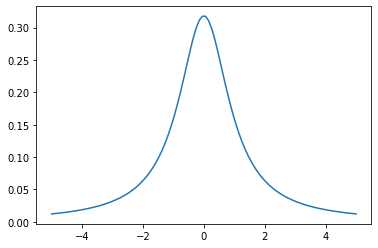

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def cauchy(x: np.ndarray):
    return 1/np.pi/(1+x*x)

x = np.linspace(-5, 5, 100)
y = cauchy(x)

plt.plot(x, y)
plt.show()

サンプルデータ生成

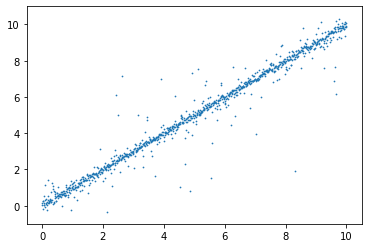

In [70]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

iteration の回数の目安は以下の通り：

1. データ分布から、1回のサンプリングで inlier を引き当てる確率 $e$ を仮定
2. 1回の試行でのサンプル数を $n$ とすると、それらのサンプルが全て inlier である確率は $e^n$
3. 一方で$N$回の試行で 2. が1回も生じない場合(RANSAC が失敗する場合)の確率は$(1-e^n)^N$
4. つまり RANSAC をほぼ確実(確率$p\sim1$)で成功させたい場合は
\begin{equation}
1-p=(1-e^n)^N⇔N=\frac{\ln(1-p)}{\ln(1-e^n)}
\end{equation}
くらいの$N$に設定して反復する。
4. 更に早期終了を目指す場合は、最大の inlier 数更新のタイミングで $e\sim$  (inlier とした数)/(データ数) として$N$を更新

In [71]:
# データの目視確認より 9/10 は対象データと想定
e = 9/10
# 直線のパラメータは2個 → サンプリング数は2個で十分
n = 2
# 99.99% の確率で RANSAC を成功させる
p = 0.9999
# zero division error 対策
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

5


乱数生成

In [72]:
index_mat = np.random.randint(0, point_num, (max_iteration, 2))
print(index_mat)

[[718 358]
 [314 773]
 [750 158]
 [983  50]
 [249 471]]


ランダムサンプリング

In [73]:
np.array([x[index_mat], y[index_mat]]).shape

(2, 5, 2)

In [74]:
# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)

print(samples_tensor.shape)
print(samples_tensor)

(5, 2, 2)
[[[ 7.18718719  7.19618173]
  [ 3.58358358  3.56749756]]

 [[ 3.14314314  3.11212802]
  [ 7.73773774  7.72687176]]

 [[ 7.50750751  7.48500235]
  [ 1.58158158  1.71140067]]

 [[ 9.83983984 10.06952705]
  [ 0.5005005   0.53036463]]

 [[ 2.49249249  4.99306757]
  [ 4.71471471  4.1758676 ]]]


傾きと切片計算

In [75]:
params_tensor = np.array([np.polyfit(sample[:, 0], sample[:, 1], 1) 
                          for sample in samples_tensor])

inlier の数を計算 → 最も良い候補を選択

In [76]:
def polynomial(params, points):
    max_degree = len(params)
    # shape=(params, points)
    terms = np.array([params[degree] * points[:, 0] ** (max_degree - degree - 1)
                      for degree in range(max_degree)])
    return np.sum(terms, axis=0)

def get_distances(params, points):
    y_est = polynomial(params, points)
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

0


結果を確認

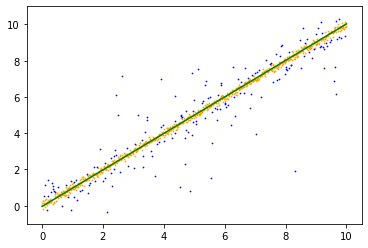

In [77]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(params, points),
         color="green")
plt.ylim(-1, 11)
plt.show()

再フィッティング

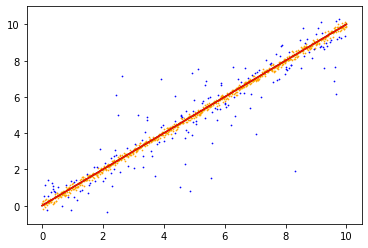

In [78]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 1)

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.ylim(-1, 11)
plt.show()

## 2次曲線フィッティング

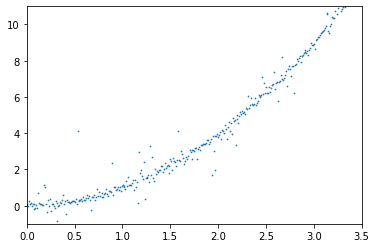

In [79]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x**2 + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

In [80]:
e = 6/10
n = 3
p = 0.9999
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

37


In [81]:
index_mat = np.random.randint(0, point_num, (max_iteration, 3))

# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)
print(samples_tensor.shape)

(37, 3, 2)


In [82]:
params_tensor = np.array([
    np.polyfit(sample[:, 0], sample[:, 1], 2)
    for sample in samples_tensor])

<ipython-input-82-5d1e57feb8fb>:1: RankWarning: Polyfit may be poorly conditioned
  params_tensor = np.array([


In [83]:
def get_distances(params, points):
    y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

11


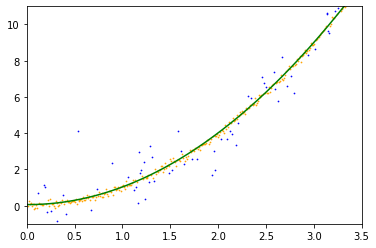

In [84]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
plt.plot(points[:, 0], y_est, color="green")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

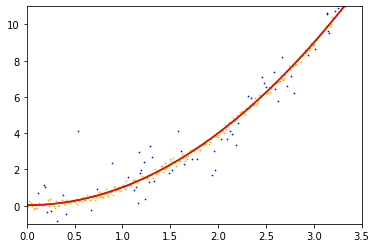

In [85]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 2)
y_refined =  refined_params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")


plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

## 陰関数フィッティング(楕円)

これまでの処理を踏まえて、RANSAC を行うための一般的なクラスを定義する

In [86]:
class RANSAC:
    def __init__(self, target_func, regressor, metric, target_prob=0.9999):
        self.target_func = target_func
        self.regressor = regressor
        self.metric = metric

        self.target_prob = target_prob
    
    def criteria(self, inlier_prob, degree):
        # zero division error 対策
        return int(np.log(1-self.target_prof)/_) \
            if not np.isclose((_ := np.log(1-inlier_prob**degree)), 0) else 1e+5

    def execute(self, data, distance_th=0.3):
        data_num = len(data)
        degree = len(self.regressor(data))
        # 最悪のケースとして inlier がデータの 1/10 と仮定
        inlier_prob = 0.1
        max_iteration = self.criteria(inlier_prob, degree)

        iteration=0
        best_inlier_bool = [False for _ in range(data_num)]
        best_inlier_num = 0
        while(iteration < max_iteration):
            # ランダムサンプリング
            rand_idx = np.random.randint(0, point_num, degree)
            # フィッティング
            params = self.regressor(data[rand_idx])
            distances = self.metric(params, data)

            # inlier 判定
            inlier_bool = distances < distance_th                
            inlier_num = np.sum(inlier_bool)
            if (inlier_num > best_inlier_num):
                best_inlier_bool = inlier_bool
                # 繰り返し回数の再判定
                max_iteration = min(
                    max_iteration, self.criteria(inlier_num/data_num, degree))
        best_params = self.regressor(data[best_inlier_bool])
        return best_params

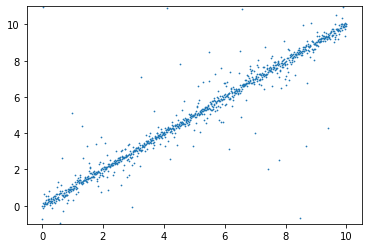

In [87]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

In [ ]:
def linear_implicit_func(params, points):
    return params[0] * points[:, 0] + params[1] * points[:, 1] + params[2]

def get_distances(params, points):
    return linear_implicit_func(params, points)